# Flat Image Net - Evaluate Results

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [7]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [8]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_model_eval', graph=graph, remove_existing=True)

## Run Net

In [9]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(20000):
        _images, _labels = data.train.next_batch(100)
        
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels})
        if iteration % 10 == 0:
            _summary, = session.run([merge_summaries],feed_dict={images: _images, labels: _labels})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            
        if iteration % 100 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images})

Iteration 0: loss 2.284402370452881, accuracy 0.11980000138282776
Iteration 100: loss 1.7489923238754272, accuracy 0.7552000284194946
Iteration 200: loss 1.6955312490463257, accuracy 0.7850000262260437
Iteration 300: loss 1.6715431213378906, accuracy 0.8108000159263611
Iteration 400: loss 1.6524304151535034, accuracy 0.8271999955177307
Iteration 500: loss 1.6396242380142212, accuracy 0.8360000252723694
Iteration 600: loss 1.632519006729126, accuracy 0.8416000008583069
Iteration 700: loss 1.6275767087936401, accuracy 0.8443999886512756
Iteration 800: loss 1.6240447759628296, accuracy 0.8452000021934509
Iteration 900: loss 1.62037992477417, accuracy 0.850600004196167
Iteration 1000: loss 1.6222776174545288, accuracy 0.8465999960899353
Iteration 1100: loss 1.6169079542160034, accuracy 0.8496000170707703
Iteration 1200: loss 1.6213759183883667, accuracy 0.8482000231742859
Iteration 1300: loss 1.6117937564849854, accuracy 0.8550000190734863
Iteration 1400: loss 1.6140224933624268, accuracy 

Iteration 12000: loss 1.579109787940979, accuracy 0.8841999769210815
Iteration 12100: loss 1.580450415611267, accuracy 0.8808000087738037
Iteration 12200: loss 1.576168417930603, accuracy 0.8866000175476074
Iteration 12300: loss 1.5786744356155396, accuracy 0.8838000297546387
Iteration 12400: loss 1.5805234909057617, accuracy 0.8812000155448914
Iteration 12500: loss 1.5781805515289307, accuracy 0.8835999965667725
Iteration 12600: loss 1.5835537910461426, accuracy 0.8773999810218811
Iteration 12700: loss 1.5811302661895752, accuracy 0.8791999816894531
Iteration 12800: loss 1.5809623003005981, accuracy 0.8802000284194946
Iteration 12900: loss 1.5835334062576294, accuracy 0.8772000074386597
Iteration 13000: loss 1.5787259340286255, accuracy 0.8827999830245972
Iteration 13100: loss 1.5790154933929443, accuracy 0.8849999904632568
Iteration 13200: loss 1.5830931663513184, accuracy 0.878600001335144
Iteration 13300: loss 1.5812119245529175, accuracy 0.8802000284194946
Iteration 13400: loss 1.

In [10]:
_prediction

array([[  3.23238344e-26,   1.70910973e-30,   3.70421404e-30, ...,
          7.92642336e-15,   5.97072625e-16,   1.00000000e+00],
       [  1.00000000e+00,   1.08329177e-25,   5.79247534e-18, ...,
          6.70139338e-33,   2.25491990e-22,   3.53052356e-26],
       [  9.11691070e-01,   5.04949479e-04,   1.02292502e-03, ...,
          3.11877923e-09,   8.07674372e-10,   6.98475517e-08],
       ..., 
       [  1.96801253e-07,   4.42843939e-12,   1.08188314e-09, ...,
          1.30741691e-05,   7.92182709e-06,   1.08697141e-05],
       [  4.88103007e-14,   4.61292184e-16,   2.45196663e-08, ...,
          2.98026664e-33,   1.00000000e+00,   1.13789334e-27],
       [  6.26490637e-09,   2.84092636e-07,   7.68598873e-09, ...,
          1.35160532e-13,   8.72221584e-09,   3.03041792e-09]], dtype=float32)

## Load reuslts to pandas df

In [10]:
from utils.results_evaluation import get_info_df

df = get_info_df(data.validation.labels, _prediction, class_id2class_name_mapping, images=data.validation.images)
df

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Ankle boot,1.000000,Ankle boot,Ankle boot,1.000000,1.000000
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0...",T-shirt/top,1.000000,T-shirt/top,T-shirt/top,1.000000,1.000000
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.928943,T-shirt/top,T-shirt/top,0.928943,0.928943
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129...",Dress,0.173901,Shirt,Dress,0.815693,0.173901
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",T-shirt/top,0.008813,Dress,T-shirt/top,0.989628,0.008813
5,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Pullover,1.000000,Pullover,Pullover,1.000000,1.000000
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sneaker,0.999999,Sneaker,Sneaker,0.999999,0.999999
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.003921...",Pullover,0.000131,Coat,Pullover,0.999868,0.000131
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sandal,1.000000,Sandal,Sandal,1.000000,1.000000


In [11]:
df.columns

Index(['image', 'label_class_name', 'label_class_score',
       'predicted_class_name_top1', 'predicted_class_name_top3',
       'predicted_class_score_top1', 'predicted_class_score_top3'],
      dtype='object')

## Precision

In [14]:
def get_precision(df, class_name):
    true_positives = len(df[(df.label_class_name==class_name) & (df.predicted_class_name_top1==class_name)])
    positives = len(df[(df.predicted_class_name_top1==class_name)])
    if positives == 0:
        positives = 1
    return round(true_positives / positives * 100, 2)

In [15]:
get_precision(df, 'T-shirt/top')

79.8

## Recall

In [16]:
def get_recall(df, class_name):
    ###################
    # Complete recall #
    ###################
    return 0

In [17]:
get_recall(df, 'T-shirt/top')

0

## Accuracy

In [18]:
def get_accuracy(df):
    #####################
    # Complete accuracy #
    #####################
    return 0

In [19]:
get_accuracy(df)

0

## Overall Recall and Precision

In [20]:
def get_rec_prec(df, class_id2class_name_mapping):
    return pd.DataFrame(
        {
            "class_name": [class_name for class_name in class_id2class_name_mapping.values()],
            "recall": [get_recall(df, class_name) for class_name in class_id2class_name_mapping.values()],
            "precision": [get_precision(df, class_name) for class_name in class_id2class_name_mapping.values()]
        })

In [31]:
get_rec_prec(df, class_id2class_name_mapping).sort_values(by='recall')

,class_name,precision,recall
6,Shirt,74.44,67.95
4,Coat,81.88,80.53
2,Pullover,80.71,81.35
0,T-shirt/top,79.80,85.56
3,Dress,89.48,90.02
7,Sneaker,94.92,94.92
5,Sandal,96.93,96.15
9,Ankle boot,95.12,96.25
1,Trouser,99.45,97.12
8,Bag,93.16,97.35


## False Positives

In [24]:
def get_false_positives(df, label_class_name, predicted_class_name=None):
    condition = (df['label_class_name']==label_class_name) & (df['predicted_class_name_top1']!=label_class_name)
    ####################################################
    # Specify false positives for certain target class #
    ####################################################
    return df[condition].sort_values(by='predicted_class_score_top1', ascending=False)



In [25]:
fp = get_false_positives(df, 'Shirt')
fp

,image,label_class_name,label_class_score,predicted_class_name_top1,predicted_class_name_top3,predicted_class_score_top1,predicted_class_score_top3
523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,1.412188e-08,T-shirt/top,Shirt,1.000000,1.412188e-08
3946,"[0.0, 0.0, 0.00784314, 0.00392157, 0.00392157,...",Shirt,1.825872e-09,T-shirt/top,Shirt,1.000000,1.825872e-09
1009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,2.734770e-13,Coat,Shirt,1.000000,2.734770e-13
2658,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.333333, ...",Shirt,3.168736e-09,T-shirt/top,Shirt,1.000000,3.168736e-09
2012,"[0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0, 0.0, 0.0...",Shirt,6.192091e-11,T-shirt/top,Shirt,1.000000,6.192091e-11
4814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0196078,...",Shirt,9.194481e-18,T-shirt/top,Shirt,1.000000,9.194481e-18
4031,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,3.653181e-09,T-shirt/top,Shirt,1.000000,3.653181e-09
3298,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Shirt,2.028843e-08,T-shirt/top,Shirt,1.000000,2.028843e-08
2131,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.243...",Shirt,3.682280e-14,T-shirt/top,Sandal,1.000000,1.226021e-11
502,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00392157, 0.0...",Shirt,3.557579e-09,Coat,Shirt,1.000000,3.557579e-09


In [26]:
def plot_examples(df, img_shape=(28, 28)):
    examples_count = min(25, len(df))
    cols = 5
    rows = np.ceil(examples_count / cols)
    
    fig = plt.figure(figsize=(20,25))
    for img_id in range(examples_count):
        ax = plt.subplot(rows, cols, img_id+1)

        img = df.image.iloc[img_id]
        if img is None:
            continue
        img = img.reshape(img_shape)
        prediction_name = df.predicted_class_name_top1.iloc[img_id]
        prediction_score = df.predicted_class_score_top1.iloc[img_id]

        ax.imshow(img , cmap='gray')
        ax.set_title("{0}: {1}".format(prediction_name, round(prediction_score, 2)))
        ax.axes.set_axis_off()

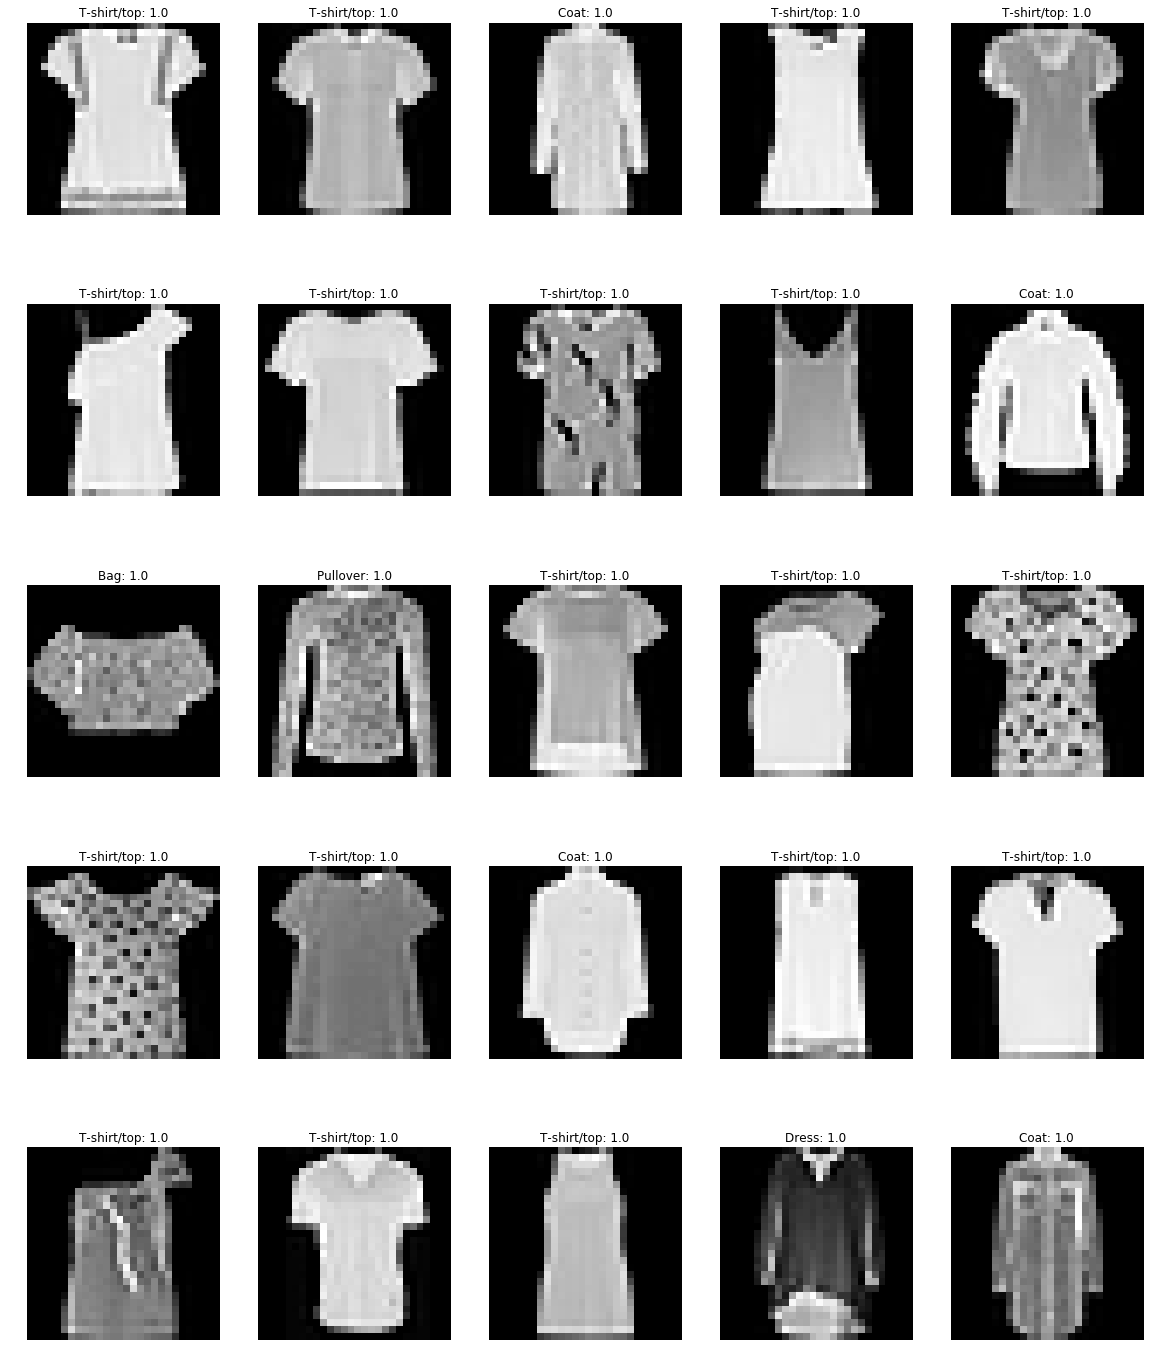

In [27]:
plot_examples(fp)

## Coocurance matrix

In [28]:
def plot_coocurance_matrix(df, use_log=False, use_top3=False):
    if use_top3:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top3']
    else:
        coocurance_cols = ['label_class_name', 'predicted_class_name_top1']
    coocurance_df = pd.pivot_table(df[coocurance_cols], index=coocurance_cols[0], 
                                   columns=coocurance_cols[1], aggfunc=len, fill_value=0)
    if use_log:
        pass
        ###################
        # Add log version #
        ###################

    coocurance_df = coocurance_df.div(coocurance_df.sum(axis=1), axis=0) * 100
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.gca()
    sns.heatmap(coocurance_df, ax=ax, annot=True,  linewidths=.5, 
                cbar_kws={"orientation": "horizontal"}, cmap="YlGnBu")

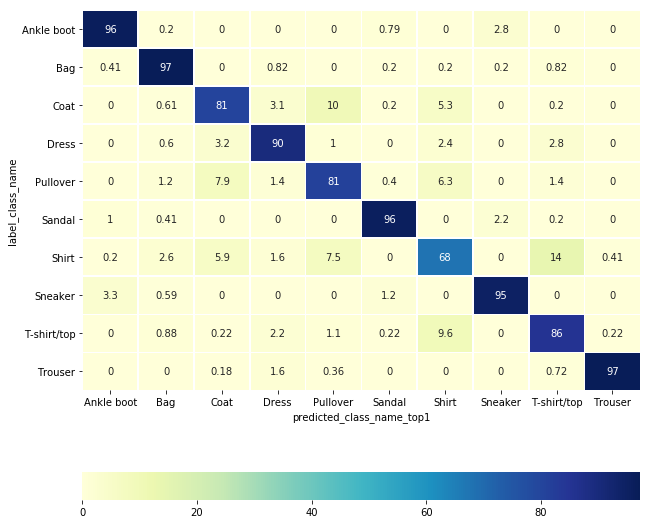

In [29]:
plot_coocurance_matrix(df, use_log=False)

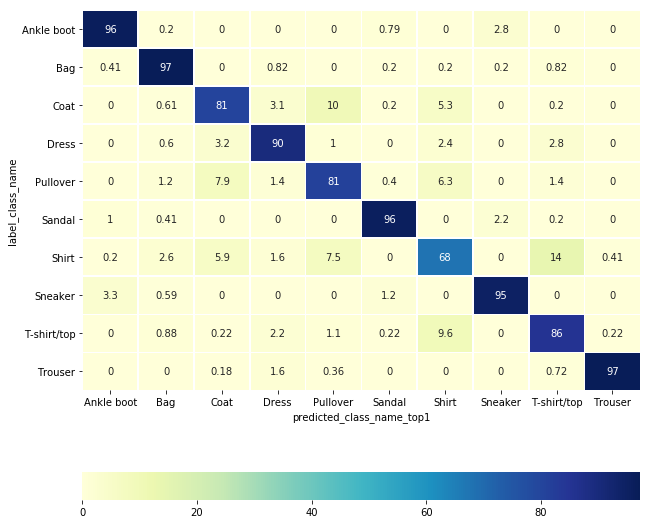

In [30]:
plot_coocurance_matrix(df, use_log=True)